In [0]:
import json
import requests

from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, LSTM, GRU
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import mean_absolute_error

sns.set_palette('Set2')
%matplotlib inline

#데이터 로드

In [8]:
from google.colab import files
uploaded = files.upload()

Saving new_train_2.csv to new_train_2.csv


In [0]:
import io
df2 = pd.read_csv(io.BytesIO(uploaded['new_train_2.csv']))

##데이터 확인

In [261]:
df2

,Date,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,Unnamed: 10,Unnamed: 11,Unnamed: 12,Unnamed: 13,Unnamed: 14,Unnamed: 15,Unnamed: 16,Unnamed: 17,Unnamed: 18,Unnamed: 19,Unnamed: 20,Unnamed: 21,Unnamed: 22,Unnamed: 23,Unnamed: 24,Unnamed: 25,Unnamed: 26,Unnamed: 27,Unnamed: 28,Unnamed: 29,Unnamed: 30,Unnamed: 31,Unnamed: 32,Unnamed: 33,Unnamed: 34,PM10,PM2.5
0,2017.1.1,1.7,250,0.6,140,0.5,360,0.9,200.0,2.7,250.0,3.0,230,1.8,290,0.8,70,0.6,90,0.5,250,0.5,160,0.8,50.0,3.0,320,0.5,270,0.9,230,0.6,90.0,0.8,250,73,40
1,2017.1.2,2.5,270,1.3,250,1.0,20,1.6,270.0,2.9,230.0,2.6,230,2.1,290,1.7,290,1.2,90,0.6,270,0.6,250,1.5,360.0,3.2,320,0.7,270,1.0,250,1.1,230.0,1.1,290,83,50
2,2017.1.3,2.0,290,1.2,250,1.2,200,1.3,200.0,2.7,230.0,2.3,230,2.1,340,1.2,230,1.0,140,0.7,290,1.0,270,1.3,20.0,5.0,320,1.5,290,0.7,180,0.7,70.0,1.0,250,124,83
3,2017.1.4,2.2,290,1.0,20,0.7,20,1.1,340.0,3.0,270.0,1.8,230,1.7,340,1.7,340,0.9,90,0.6,290,0.4,20,1.2,360.0,3.4,290,0.6,270,0.5,70,0.8,340.0,0.8,250,113,70
4,2017.1.5,1.5,290,1.3,20,1.8,50,1.7,70.0,3.3,290.0,4.0,70,2.1,320,2.6,50,1.9,90,1.4,90,1.3,110,1.2,20.0,2.0,140,0.5,70,1.1,50,1.5,90.0,1.2,270,121,78
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
906,2019.06.26,1.3,110,0.7,340,1.2,340,1.3,50.0,2.0,160.0,0.9,50,1.2,320,1.2,250,1.7,110,0.9,110,1.0,160,0.9,110.0,1.2,320,0.6,270,0.8,200,2.0,110.0,1.1,320,30,22
907,2019.06.27,2.0,360,1.2,250,1.2,340,1.3,50.0,1.8,160.0,1.0,20,1.4,180,1.8,250,0.8,140,1.1,290,1.2,320,1.2,360.0,1.1,180,0.5,320,0.7,180,2.3,110.0,1.3,140,19,14
908,2019.06.28,1.8,140,1.4,270,1.6,340,2.0,200.0,2.0,340.0,2.1,50,1.4,70,1.7,250,1.0,290,1.3,290,1.4,320,0.9,270.0,0.9,160,1.1,110,1.7,230,1.8,110.0,1.4,70,50,40
909,2019.06.29,1.1,110,0.8,140,1.3,340,1.2,50.0,1.5,160.0,1.0,230,1.0,200,0.8,90,1.2,90,0.6,140,0.7,110,1.0,140.0,1.0,160,0.7,110,0.8,20,1.8,110.0,0.8,250,26,23


##빈컬럼 처리

In [262]:
#빈컬럼 확인
df2.isnull().sum()

Date           0
Unnamed: 1     0
Unnamed: 2     0
Unnamed: 3     0
Unnamed: 4     0
Unnamed: 5     0
Unnamed: 6     0
Unnamed: 7     3
Unnamed: 8     6
Unnamed: 9     0
Unnamed: 10    1
Unnamed: 11    0
Unnamed: 12    0
Unnamed: 13    1
Unnamed: 14    0
Unnamed: 15    0
Unnamed: 16    0
Unnamed: 17    0
Unnamed: 18    0
Unnamed: 19    0
Unnamed: 20    0
Unnamed: 21    0
Unnamed: 22    0
Unnamed: 23    0
Unnamed: 24    9
Unnamed: 25    0
Unnamed: 26    0
Unnamed: 27    0
Unnamed: 28    0
Unnamed: 29    0
Unnamed: 30    0
Unnamed: 31    0
Unnamed: 32    1
Unnamed: 33    0
Unnamed: 34    0
PM10           0
PM2.5          0
dtype: int64

In [263]:
#8번 컬럼의 NAN이라고 표기된 데이터 확인
df2[df2['Unnamed: 8'].isnull()]

,Date,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,Unnamed: 10,Unnamed: 11,Unnamed: 12,Unnamed: 13,Unnamed: 14,Unnamed: 15,Unnamed: 16,Unnamed: 17,Unnamed: 18,Unnamed: 19,Unnamed: 20,Unnamed: 21,Unnamed: 22,Unnamed: 23,Unnamed: 24,Unnamed: 25,Unnamed: 26,Unnamed: 27,Unnamed: 28,Unnamed: 29,Unnamed: 30,Unnamed: 31,Unnamed: 32,Unnamed: 33,Unnamed: 34,PM10,PM2.5
361,2017.12.28,1.5,290,0.7,50,0.6,360,0.5,NaN,2.4,250.0,2.9,250,2.3,340,0.7,50,0.8,70,0.6,290,0.7,360,1.0,20.0,3.6,320,1.4,320,0.6,200,1.5,340.0,0.7,250,72,40
366,2018.1.2,2.9,290,1.8,320,1.2,20,NaN,NaN,2.5,230.0,2.7,250,1.9,320,1.6,230,0.9,230,0.8,270,0.7,340,1.7,360.0,6.0,290,1.0,290,0.9,200,1.1,290.0,1.1,250,84,45
367,2018.1.3,1.6,290,1.5,320,0.9,360,2.2,NaN,2.2,250.0,2.7,250,2.7,320,1.8,270,1.7,290,1.2,270,1.3,320,3.2,360.0,5.6,320,1.7,290,1.0,140,1.8,290.0,1.0,250,55,27
569,2018.7.24,1.3,160,1.3,320,1.4,250,1.1,NaN,1.7,140.0,2.2,250,1.5,140,1.5,250,1.1,230,1.1,290,0.9,140,2.3,200.0,1.6,320,1.1,290,1.6,200,2.3,200.0,1.2,230,26,13
802,2019.03.14,2.2,270,1.2,20,1.3,340,2.2,NaN,2.7,250.0,2.7,250,2.1,140,1.8,250,1.6,230,1.5,270,1.2,320,1.7,270.0,3.2,320,1.0,290,1.3,200,1.9,290.0,1.7,270,51,23
880,2019.05.31,2.7,270,2.6,270,2.6,250,NaN,NaN,2.7,250.0,2.8,230,2.3,200,3.4,250,1.6,290,1.2,290,1.5,340,1.1,20.0,3.3,320,1.5,290,1.7,180,1.7,250.0,1.3,270,27,19


In [0]:
#빈 데이터를 위의 값으로 채운다.
new_df = df2.fillna(method='pad')

In [265]:
#채운 데이터 확인
new_df[380:571]

,Date,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,Unnamed: 10,Unnamed: 11,Unnamed: 12,Unnamed: 13,Unnamed: 14,Unnamed: 15,Unnamed: 16,Unnamed: 17,Unnamed: 18,Unnamed: 19,Unnamed: 20,Unnamed: 21,Unnamed: 22,Unnamed: 23,Unnamed: 24,Unnamed: 25,Unnamed: 26,Unnamed: 27,Unnamed: 28,Unnamed: 29,Unnamed: 30,Unnamed: 31,Unnamed: 32,Unnamed: 33,Unnamed: 34,PM10,PM2.5
380,2018.1.16,2.1,290,1.2,360,0.7,340,1.0,20.0,2.5,230.0,1.5,230,1.7,340,1.1,70,0.6,90,0.8,110,0.6,340,1.4,20.0,1.4,340,0.5,270,0.8,70,0.8,70.0,0.7,320,66,47
381,2018.1.17,1.7,340,1.3,250,1.2,200,1.2,360.0,2.8,320.0,1.7,250,2.2,340,1.4,270,0.8,90,0.7,140,0.8,230,1.9,360.0,1.5,320,0.9,290,0.8,70,1.0,180.0,0.7,270,54,42
382,2018.1.18,1.7,290,1.1,360,1.2,200,1.1,340.0,2.3,250.0,2.0,230,2.1,340,1.3,320,1.1,250,0.9,290,1.0,320,2.1,340.0,4.3,320,1.1,290,0.7,70,0.6,360.0,0.7,250,130,89
383,2018.1.19,1.4,290,1.2,270,0.9,340,0.9,20.0,2.2,270.0,2.7,230,2.6,340,1.4,270,1.0,270,0.7,270,0.8,320,1.8,340.0,3.0,290,1.4,320,0.7,20,1.1,290.0,1.0,250,105,58
384,2018.1.20,2.2,270,1.3,270,0.8,360,1.0,200.0,2.6,250.0,2.3,230,2.2,340,1.5,360,0.9,90,0.5,320,0.6,20,0.9,90.0,2.4,320,0.8,290,0.8,200,0.9,270.0,0.8,250,95,49
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
566,2018.7.21,1.7,160,1.2,20,1.3,340,1.5,50.0,2.5,160.0,2.7,250,1.8,140,1.6,230,0.9,200,0.8,90,0.7,160,1.3,360.0,1.5,180,0.9,270,1.3,200,1.5,110.0,1.1,250,67,55
567,2018.7.22,1.3,110,1.2,320,1.4,360,1.3,50.0,2.5,160.0,2.9,230,1.8,200,1.4,50,0.8,50,1.3,180,1.0,200,2.7,140.0,1.5,180,1.0,290,1.3,200,1.0,290.0,1.1,250,35,25
568,2018.7.23,1.1,140,1.2,340,1.4,340,1.4,320.0,1.8,250.0,2.3,230,1.6,290,1.7,270,0.9,250,0.9,20,0.9,250,2.0,140.0,1.5,320,0.9,270,1.2,200,1.6,200.0,1.1,250,27,14
569,2018.7.24,1.3,160,1.3,320,1.4,250,1.1,320.0,1.7,140.0,2.2,250,1.5,140,1.5,250,1.1,230,1.1,290,0.9,140,2.3,200.0,1.6,320,1.1,290,1.6,200,2.3,200.0,1.2,230,26,13


###Date 컬럼을 인덱스로 설정

In [0]:
new_df = new_df.set_index('Date')


In [267]:
#인덱스로 잘 설정되었는지 확인
new_df

,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,Unnamed: 10,Unnamed: 11,Unnamed: 12,Unnamed: 13,Unnamed: 14,Unnamed: 15,Unnamed: 16,Unnamed: 17,Unnamed: 18,Unnamed: 19,Unnamed: 20,Unnamed: 21,Unnamed: 22,Unnamed: 23,Unnamed: 24,Unnamed: 25,Unnamed: 26,Unnamed: 27,Unnamed: 28,Unnamed: 29,Unnamed: 30,Unnamed: 31,Unnamed: 32,Unnamed: 33,Unnamed: 34,PM10,PM2.5
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2017.1.1,1.7,250,0.6,140,0.5,360,0.9,200.0,2.7,250.0,3.0,230,1.8,290,0.8,70,0.6,90,0.5,250,0.5,160,0.8,50.0,3.0,320,0.5,270,0.9,230,0.6,90.0,0.8,250,73,40
2017.1.2,2.5,270,1.3,250,1.0,20,1.6,270.0,2.9,230.0,2.6,230,2.1,290,1.7,290,1.2,90,0.6,270,0.6,250,1.5,360.0,3.2,320,0.7,270,1.0,250,1.1,230.0,1.1,290,83,50
2017.1.3,2.0,290,1.2,250,1.2,200,1.3,200.0,2.7,230.0,2.3,230,2.1,340,1.2,230,1.0,140,0.7,290,1.0,270,1.3,20.0,5.0,320,1.5,290,0.7,180,0.7,70.0,1.0,250,124,83
2017.1.4,2.2,290,1.0,20,0.7,20,1.1,340.0,3.0,270.0,1.8,230,1.7,340,1.7,340,0.9,90,0.6,290,0.4,20,1.2,360.0,3.4,290,0.6,270,0.5,70,0.8,340.0,0.8,250,113,70
2017.1.5,1.5,290,1.3,20,1.8,50,1.7,70.0,3.3,290.0,4.0,70,2.1,320,2.6,50,1.9,90,1.4,90,1.3,110,1.2,20.0,2.0,140,0.5,70,1.1,50,1.5,90.0,1.2,270,121,78
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019.06.26,1.3,110,0.7,340,1.2,340,1.3,50.0,2.0,160.0,0.9,50,1.2,320,1.2,250,1.7,110,0.9,110,1.0,160,0.9,110.0,1.2,320,0.6,270,0.8,200,2.0,110.0,1.1,320,30,22
2019.06.27,2.0,360,1.2,250,1.2,340,1.3,50.0,1.8,160.0,1.0,20,1.4,180,1.8,250,0.8,140,1.1,290,1.2,320,1.2,360.0,1.1,180,0.5,320,0.7,180,2.3,110.0,1.3,140,19,14
2019.06.28,1.8,140,1.4,270,1.6,340,2.0,200.0,2.0,340.0,2.1,50,1.4,70,1.7,250,1.0,290,1.3,290,1.4,320,0.9,270.0,0.9,160,1.1,110,1.7,230,1.8,110.0,1.4,70,50,40


In [0]:
#예측할 컬럼 설정
target_col='PM10'

if target_col == "PM2.5":
    drop_col = "PM10"
else: drop_col = "PM2.5"

In [0]:
new_df = new_df.drop(drop_col, 1)

In [0]:
#데이터 정규화

def normalize(df):

    df1 = df[df.columns[0:34:2]] / 10
    df2 = df[df.columns[1:35:2]] / 360
    df3 = df[df.columns[-1]] / 200

    new_df = pd.concat([df1, df2, df3], axis=1)

    return new_df




In [0]:
new_df = normalize(new_df)

In [272]:
#최종 학습데이터 확인
new_df

,Unnamed: 1,Unnamed: 3,Unnamed: 5,Unnamed: 7,Unnamed: 9,Unnamed: 11,Unnamed: 13,Unnamed: 15,Unnamed: 17,Unnamed: 19,Unnamed: 21,Unnamed: 23,Unnamed: 25,Unnamed: 27,Unnamed: 29,Unnamed: 31,Unnamed: 33,Unnamed: 2,Unnamed: 4,Unnamed: 6,Unnamed: 8,Unnamed: 10,Unnamed: 12,Unnamed: 14,Unnamed: 16,Unnamed: 18,Unnamed: 20,Unnamed: 22,Unnamed: 24,Unnamed: 26,Unnamed: 28,Unnamed: 30,Unnamed: 32,Unnamed: 34,PM10
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2017.1.1,0.17,0.06,0.05,0.09,0.27,0.30,0.18,0.08,0.06,0.05,0.05,0.08,0.30,0.05,0.09,0.06,0.08,0.694444,0.388889,1.000000,0.555556,0.694444,0.638889,0.805556,0.194444,0.250000,0.694444,0.444444,0.138889,0.888889,0.750000,0.638889,0.250000,0.694444,0.365
2017.1.2,0.25,0.13,0.10,0.16,0.29,0.26,0.21,0.17,0.12,0.06,0.06,0.15,0.32,0.07,0.10,0.11,0.11,0.750000,0.694444,0.055556,0.750000,0.638889,0.638889,0.805556,0.805556,0.250000,0.750000,0.694444,1.000000,0.888889,0.750000,0.694444,0.638889,0.805556,0.415
2017.1.3,0.20,0.12,0.12,0.13,0.27,0.23,0.21,0.12,0.10,0.07,0.10,0.13,0.50,0.15,0.07,0.07,0.10,0.805556,0.694444,0.555556,0.555556,0.638889,0.638889,0.944444,0.638889,0.388889,0.805556,0.750000,0.055556,0.888889,0.805556,0.500000,0.194444,0.694444,0.620
2017.1.4,0.22,0.10,0.07,0.11,0.30,0.18,0.17,0.17,0.09,0.06,0.04,0.12,0.34,0.06,0.05,0.08,0.08,0.805556,0.055556,0.055556,0.944444,0.750000,0.638889,0.944444,0.944444,0.250000,0.805556,0.055556,1.000000,0.805556,0.750000,0.194444,0.944444,0.694444,0.565
2017.1.5,0.15,0.13,0.18,0.17,0.33,0.40,0.21,0.26,0.19,0.14,0.13,0.12,0.20,0.05,0.11,0.15,0.12,0.805556,0.055556,0.138889,0.194444,0.805556,0.194444,0.888889,0.138889,0.250000,0.250000,0.305556,0.055556,0.388889,0.194444,0.138889,0.250000,0.750000,0.605
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019.06.26,0.13,0.07,0.12,0.13,0.20,0.09,0.12,0.12,0.17,0.09,0.10,0.09,0.12,0.06,0.08,0.20,0.11,0.305556,0.944444,0.944444,0.138889,0.444444,0.138889,0.888889,0.694444,0.305556,0.305556,0.444444,0.305556,0.888889,0.750000,0.555556,0.305556,0.888889,0.150
2019.06.27,0.20,0.12,0.12,0.13,0.18,0.10,0.14,0.18,0.08,0.11,0.12,0.12,0.11,0.05,0.07,0.23,0.13,1.000000,0.694444,0.944444,0.138889,0.444444,0.055556,0.500000,0.694444,0.388889,0.805556,0.888889,1.000000,0.500000,0.888889,0.500000,0.305556,0.388889,0.095
2019.06.28,0.18,0.14,0.16,0.20,0.20,0.21,0.14,0.17,0.10,0.13,0.14,0.09,0.09,0.11,0.17,0.18,0.14,0.388889,0.750000,0.944444,0.555556,0.944444,0.138889,0.194444,0.694444,0.805556,0.805556,0.888889,0.750000,0.444444,0.305556,0.638889,0.305556,0.194444,0.250


In [0]:
# train 과 test데이터 분리
def train_test_split(df, test_size=0.05):
    split_row = len(df) - int(test_size * len(df))
    train_data = df.iloc[:split_row]
    test_data = df.iloc[split_row:]
    return train_data, test_data



In [0]:
train, test = train_test_split(new_df, test_size=0.3)

In [0]:

def line_plot(line1, line2, label1=None, label2=None, title='', lw=2):
    fig, ax = plt.subplots(1, figsize=(16, 9))
    ax.plot(line1, label=label1, linewidth=lw)
    ax.plot(line2, label=label2, linewidth=lw)
    ax.set_ylabel(target_col, fontsize=14)
    ax.set_title(title, fontsize=18)
    ax.legend(loc='best', fontsize=18);

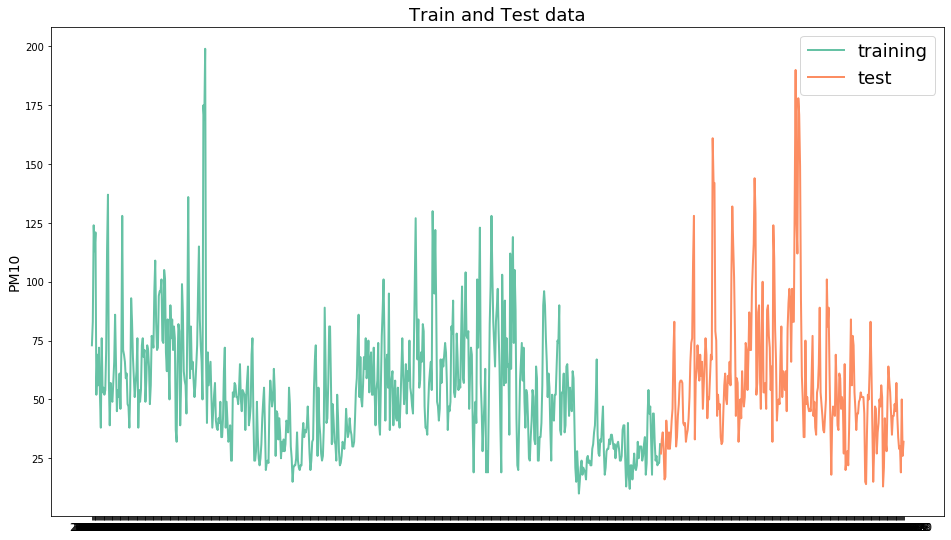

In [276]:
line_plot(train[target_col]*200, test[target_col]*200, 'training', 'test', title='Train and Test data')


In [0]:
#데이터 윈도우

def extract_window_data(df, window_len=10, zero_base=True):

    window_data = []
    for idx in range(len(df) - window_len):
        tmp = df[idx: (idx + window_len)].copy()
        #if zero_base:
        #    tmp = normalise_zero_base(tmp)
        window_data.append(tmp.values)
    return np.array(window_data)

In [0]:
def prepare_data(df, target_col, window_len=10, zero_base=True, test_size=0.2):

    # train test split
    train_data, test_data = train_test_split(df, test_size=test_size)

    
    # extract window data
    X_train = extract_window_data(train_data, window_len, zero_base)
    X_test = extract_window_data(test_data, window_len, zero_base)
    
    # extract targets
    y_train = train_data[target_col][window_len:].values
    y_test = test_data[target_col][window_len:].values
    

    return train_data, test_data, X_train, X_test, y_train, y_test

In [0]:
#LSTM모델 정의

def build_lstm_model(input_data, output_size, neurons=20, activ_func='linear',
                     dropout=0.25, loss='mae', optimizer='adam'):
    model = Sequential()

    model.add(LSTM(16, return_sequences=True, input_shape=(input_data.shape[1], input_data.shape[2])))
    model.add(LSTM(32))
    model.add(Dropout(dropout))
    model.add(Dense(units=output_size, activation='linear'))


    model.compile(loss=loss, optimizer=optimizer)
    return model

In [0]:
#하이퍼 파라메타
np.random.seed(42)

# data params
window_len = 5

#전체 데이터를 학습데이터7 : 테스트데이터3 으로 분리
test_size = 0.3


# model params
epochs = 300
batch_size = 4
loss = 'mae'
dropout = 0.25
optimizer = 'adam'

In [0]:
#학습데이터 정규화 X_train이 train데이터를 정규화한것임. X_train = 바람, y_train = 미세먼지

train, test, X_train, X_test, y_train, y_test = prepare_data(
    new_df, target_col, window_len=window_len, zero_base=zero_base, test_size=test_size)

In [313]:
#학습 시작
model = build_lstm_model(
    X_train[:,:,0:35], output_size=1, neurons=lstm_neurons, dropout=dropout, loss=loss,
    optimizer=optimizer)
history = model.fit(
    X_train[:,:,0:35], y_train, epochs=epochs, batch_size=batch_size, verbose=1, shuffle=True)

Epoch 1/300
633/633 [==============================] - 12s 18ms/step - loss: 0.1037
Epoch 2/300
633/633 [==============================] - 4s 6ms/step - loss: 0.0898
Epoch 3/300
633/633 [==============================] - 4s 6ms/step - loss: 0.0867
Epoch 4/300
633/633 [==============================] - 4s 6ms/step - loss: 0.0812
Epoch 5/300
633/633 [==============================] - 4s 7ms/step - loss: 0.0817
Epoch 6/300
633/633 [==============================] - 4s 7ms/step - loss: 0.0748
Epoch 7/300
633/633 [==============================] - 4s 7ms/step - loss: 0.0742
Epoch 8/300
633/633 [==============================] - 4s 7ms/step - loss: 0.0750
Epoch 9/300
633/633 [==============================] - 4s 6ms/step - loss: 0.0717
Epoch 10/300
633/633 [==============================] - 4s 7ms/step - loss: 0.0689
Epoch 11/300
633/633 [==============================] - 4s 7ms/step - loss: 0.0683
Epoch 12/300
633/633 [==============================] - 4s 6ms/step - loss: 0.0714
Epoch 13/30

#Training Data에 대한 평가

In [0]:
targets = train[target_col][window_len:]
preds = model.predict(X_train[:,:,0:35]).squeeze()

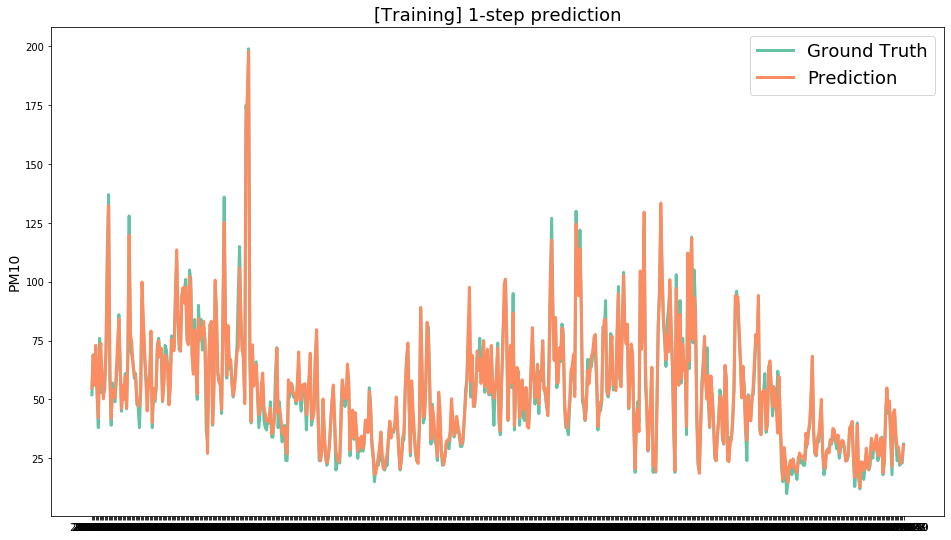

In [315]:
preds = pd.Series(index=targets.index, data=preds)

line_plot(targets*200, preds*200, 'Ground Truth', 'Prediction', lw=3, title='[Training] 1-step prediction')

#Test데이터에 대한 평가

In [0]:
targets = test[target_col][window_len:]
preds = model.predict(X_test[:,:,0:35]).squeeze()

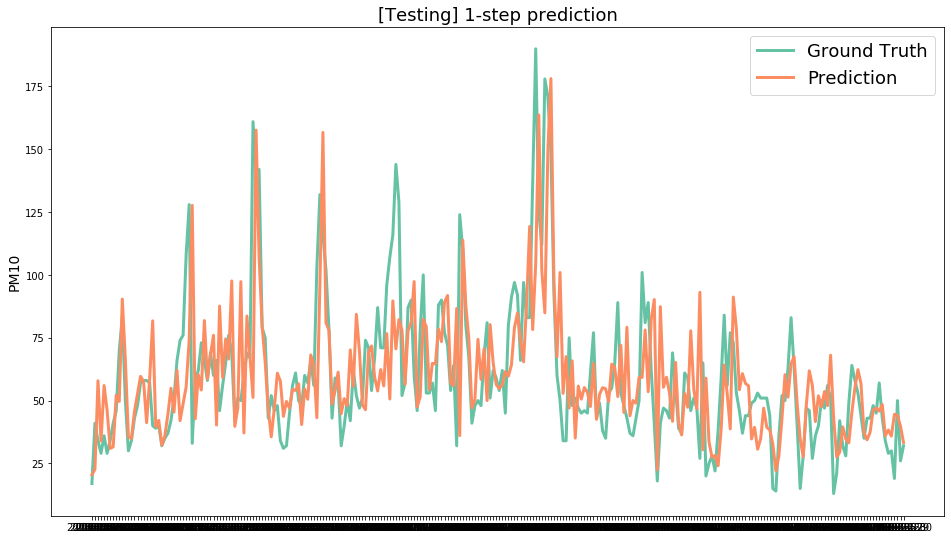

In [317]:

preds = pd.Series(index=targets.index, data=preds)

line_plot(targets*200, preds*200, 'Ground Truth', 'Prediction', lw=3, title='[Testing] 1-step prediction')

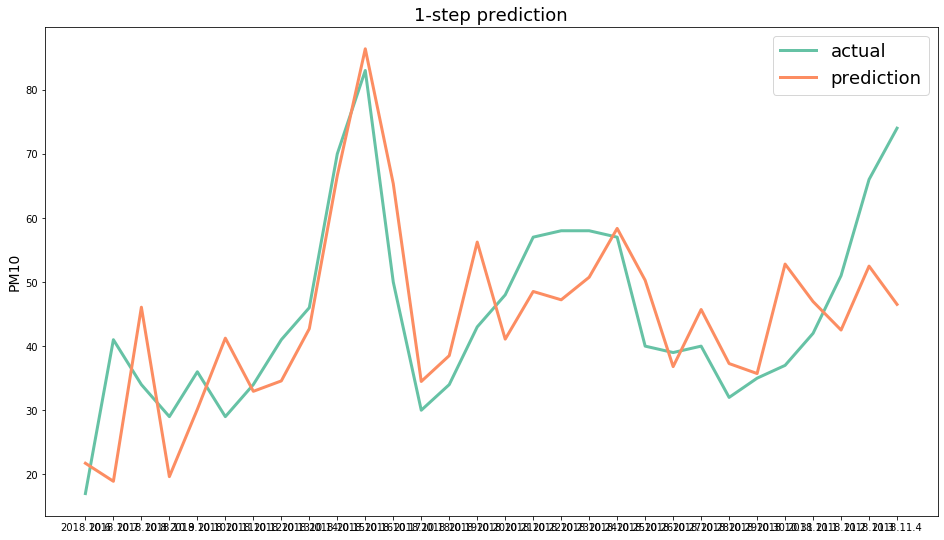

In [309]:
n_points = 30

line_plot(targets[0:n_points]*200, preds[0:n_points]*200, 'actual', 'prediction', lw=3, title='1-step prediction')

##RMSE, MSE, MAE 정량적 평가

In [318]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
import math

print("MAE = ", mean_absolute_error(targets*200, preds*200))
print("MSE = ", mean_squared_error(targets*200, preds*200))
print("RMSE = ", math.sqrt(mean_squared_error(targets*200, preds*200)))



MAE =  16.390090814277308
MSE =  573.719096970003
RMSE =  23.95243405105216
